Модели отсюда: https://github.com/natasha/navec#downloads

### Подготовка данных

In [ ]:
!pip install navec
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 47.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=b7f4801a40287dda471c7ec2b6039cc874b2943065cc799960494b31107bf10b
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar

--2023-05-31 19:00:03--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.3MB/s    in 3.4s    

2023-05-31 19:00:08 (14.9 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]

--2023-05-31 19:00:08--  https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2663

In [ ]:
import torch
from navec import Navec

path_lit = "/content/navec_hudlit_v1_12B_500K_300d_100q.tar" #модель 1
path_news = "/content/navec_news_v1_1B_250K_300d_100q.tar" #модель 2
navec_lit = Navec.load(path_lit)
navec_news = Navec.load(path_news)

In [ ]:
import gensim
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import operator
import pandas as pd
from pymorphy2 import MorphAnalyzer
import re
from sklearn.cluster import KMeans
morph = MorphAnalyzer()

In [ ]:
df = pd.read_excel(r'/content/drive/MyDrive/dataset_probe.xlsx', sheet_name = "Лист1")
v_cols = []
for line in df["контексты"]:
    cl_line = re.sub(r'[^\w\s]','', line.lower())
    words = cl_line.split()
    if "в" in words:
        v_cols.append(f"в {words[words.index('в')+1]}")
df["в + сущ"] = v_cols

### Векторизация

In [ ]:
def data_for_clustering_lemmas(some_df, navec_model):
    vecs_preplemm = [] #векторы предлог+форма сущ
    for wordc in some_df["в + сущ"]:
        prep, noun = wordc.split()
        pvec = navec_model[prep]
        try:
            nvec_lemm = navec_model[morph.normal_forms(noun)[0]]
        except:
            norm = morph.normal_forms(noun)[0].replace("ё", "е")
            nvec_lemm = navec_model[norm]
        wordc_vec_lemm = pvec + nvec_lemm
        vecs_preplemm.append(wordc_vec_lemm)
    X = np.array(vecs_preplemm)
    return X, vecs_preplemm

In [ ]:
def data_for_clustering_tokens(some_df, navec_model):
    vecs_prepform = [] #векторы предлог+форма сущ
    for wordc in some_df["в + сущ"]:
        prep, noun = wordc.split()
        pvec = navec_model[prep]
        try:
            nvec_form = navec_model[noun]
        except:
            nvec_form = navec_model[morph.normal_forms(noun)[0]]
        wordc_vec_form = pvec+nvec_form
        vecs_prepform.append(wordc_vec_form)
    X = np.array(vecs_prepform)
    return X, vecs_prepform

In [ ]:
X_hudlit_lemmas, vecs_hudlit_lemmas = data_for_clustering_lemmas(df, navec_lit)
X_news_lemmas, vecs_news_lemmas = data_for_clustering_lemmas(df, navec_news)
X_hudlit_tokens, vecs_hudlit_tokens = data_for_clustering_tokens(df, navec_lit)
X_news_tokens, vecs_news_tokens = data_for_clustering_tokens(df, navec_news)

In [ ]:
df["vecs_hudlit_lemmas"] = vecs_hudlit_lemmas
df["vecs_news_lemmas"] = vecs_news_lemmas
df["vecs_hudlit_tokens"] = vecs_hudlit_tokens
df["vecs_news_tokens"] = vecs_news_tokens

In [ ]:
df

,контексты,значение,vp,pp,в + сущ,vecs_hudlit_lemmas,vecs_news_lemmas,vecs_hudlit_tokens,vecs_news_tokens
0,"В универе очень интересно течет жизнь, постоя...",место,течет в универе,в универе,в универе,"[0.45199716, -0.3944914, -0.31565177, 0.264169...","[-0.6831895, -0.41404185, -0.55372816, 0.83120...","[0.21731496, -0.42764816, -0.56575114, 0.30487...","[-0.6831895, -0.41404185, -0.55372816, 0.83120..."
1,Растить в душе побег уныния -- преступление.,место,растить в душе,в душе,в душе,"[-0.035612658, -0.9457506, -0.504634, 0.255577...","[0.12825295, -0.1376557, -0.66368735, 0.855894...","[0.354711, -0.6737493, -0.9810307, 0.7324885, ...","[0.34850574, 0.44381613, -0.6892047, 1.0984685..."
2,В Госдуме тоже пытаются бороться с курением,место,пытаются бороться в Госдуме,в госдуме,в госдуме,"[0.27915013, -0.34622344, 0.068596065, 0.27330...","[-0.44761434, 0.17104164, 0.09498185, 0.209542...","[0.14426593, -0.014802635, -0.37672898, 0.6086...","[-0.2162426, 0.28114083, -0.16620094, 0.737299..."
3,Я старалась подольше оставаться в саду,место,старалась оставаться в саду,в саду,в саду,"[0.23879431, -1.2709154, -0.98280245, 0.417584...","[-0.052116185, -0.2041372, -0.64312166, 1.3127...","[0.23879431, -1.2709154, -0.98280245, 0.341983...","[0.18175724, 0.15446949, -0.56261134, 0.835387..."
4,"Необходимо добавить, что в Китае банковский п...",место,считается в Китае,в китае,в китае,"[0.29545915, -0.74406767, -0.4663653, 0.866244...","[-0.89129204, -0.120426215, -0.6293604, 1.0376...","[0.055876195, -0.7097049, -0.53202975, 0.61953...","[-0.80397975, -0.008775331, -0.35229075, 0.757..."
...,...,...,...,...,...,...,...,...,...
95,Во время сильной грозы молния ударила в склад ...,Направление,ударила в склад,в склад оружия,в склад,"[0.22456962, -0.8188261, -0.71653223, 0.402296...","[-0.8837431, -0.4907504, -1.0688866, 0.1391781...","[0.22456962, -0.8188261, -0.71653223, 0.402296...","[-0.8837431, -0.4907504, -1.0688866, 0.1391781..."
96,"...многие хотят полететь в космос, но потом ос...",Направление,хотят полететь в космос,в космос,в космос,"[0.354711, -0.6737493, -0.9810307, 0.48305196,...","[0.20534533, -0.3029451, -1.0030084, 1.0545409...","[0.354711, -0.6737493, -0.9810307, 0.48305196,...","[0.20534533, -0.3029451, -1.0030084, 1.0545409..."
97,А на общем снимке его взгляд направлен не в ка...,Направление,направлен не в камеру,в камеру,в камеру,"[0.45458418, -0.20599084, -0.59235424, -0.1445...","[-0.34060785, 0.04300802, -0.3559399, 0.232241...","[0.5671426, -0.59494853, -0.8890321, 0.2451688...","[0.090525866, 0.3053137, -0.54642063, -0.04360..."
98,"Молодая девица смотрела в окно, она ждала весны.",Направление,смотрела в окно,в окно,в окно,"[0.23879431, -1.2709154, -0.98280245, 0.750172...","[-0.28655815, 0.1932405, -1.0433831, 0.1591860...","[0.23879431, -1.2709154, -0.98280245, 0.750172...","[-0.28655815, 0.1932405, -1.0433831, 0.1591860..."


### Кластеризация

In [ ]:
def kmeans_clustering(n, matrix):
    kmeans = KMeans(n_clusters=n, init = "random", n_init = "auto", max_iter = 500, algorithm='elkan').fit(matrix)
    kclusters = kmeans.predict(matrix)
    return kclusters

In [ ]:
df["clusters_hudlit_lemmas"] = kmeans_clustering(4, X_hudlit_lemmas)
df["clusters_news_lemmas"] = kmeans_clustering(4, X_news_lemmas)
df["clusters_hudlit_tokens"] = kmeans_clustering(4, X_hudlit_tokens)
df["clusters_news_tokens"] = kmeans_clustering(4, X_news_tokens)

In [ ]:
df

,контексты,значение,vp,pp,в + сущ,clusters_hudlit_lemmas,clusters_news_lemmas,clusters_hudlit_tokens,clusters_news_tokens,vecs_hudlit_lemmas,vecs_news_lemmas,vecs_hudlit_tokens,vecs_news_tokens
0,"В универе очень интересно течет жизнь, постоя...",место,течет в универе,в универе,в универе,2,0,3,3,"[0.45199716, -0.3944914, -0.31565177, 0.264169...","[-0.6831895, -0.41404185, -0.55372816, 0.83120...","[0.21731496, -0.42764816, -0.56575114, 0.30487...","[-0.6831895, -0.41404185, -0.55372816, 0.83120..."
1,Растить в душе побег уныния -- преступление.,место,растить в душе,в душе,в душе,1,0,0,1,"[-0.035612658, -0.9457506, -0.504634, 0.255577...","[0.12825295, -0.1376557, -0.66368735, 0.855894...","[0.354711, -0.6737493, -0.9810307, 0.7324885, ...","[0.34850574, 0.44381613, -0.6892047, 1.0984685..."
2,В Госдуме тоже пытаются бороться с курением,место,пытаются бороться в Госдуме,в госдуме,в госдуме,2,1,3,1,"[0.27915013, -0.34622344, 0.068596065, 0.27330...","[-0.44761434, 0.17104164, 0.09498185, 0.209542...","[0.14426593, -0.014802635, -0.37672898, 0.6086...","[-0.2162426, 0.28114083, -0.16620094, 0.737299..."
3,Я старалась подольше оставаться в саду,место,старалась оставаться в саду,в саду,в саду,1,0,1,2,"[0.23879431, -1.2709154, -0.98280245, 0.417584...","[-0.052116185, -0.2041372, -0.64312166, 1.3127...","[0.23879431, -1.2709154, -0.98280245, 0.341983...","[0.18175724, 0.15446949, -0.56261134, 0.835387..."
4,"Необходимо добавить, что в Китае банковский п...",место,считается в Китае,в китае,в китае,2,1,0,0,"[0.29545915, -0.74406767, -0.4663653, 0.866244...","[-0.89129204, -0.120426215, -0.6293604, 1.0376...","[0.055876195, -0.7097049, -0.53202975, 0.61953...","[-0.80397975, -0.008775331, -0.35229075, 0.757..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Во время сильной грозы молния ударила в склад ...,Направление,ударила в склад,в склад оружия,в склад,1,0,1,0,"[0.22456962, -0.8188261, -0.71653223, 0.402296...","[-0.8837431, -0.4907504, -1.0688866, 0.1391781...","[0.22456962, -0.8188261, -0.71653223, 0.402296...","[-0.8837431, -0.4907504, -1.0688866, 0.1391781..."
96,"...многие хотят полететь в космос, но потом ос...",Направление,хотят полететь в космос,в космос,в космос,1,1,1,0,"[0.354711, -0.6737493, -0.9810307, 0.48305196,...","[0.20534533, -0.3029451, -1.0030084, 1.0545409...","[0.354711, -0.6737493, -0.9810307, 0.48305196,...","[0.20534533, -0.3029451, -1.0030084, 1.0545409..."
97,А на общем снимке его взгляд направлен не в ка...,Направление,направлен не в камеру,в камеру,в камеру,2,0,1,2,"[0.45458418, -0.20599084, -0.59235424, -0.1445...","[-0.34060785, 0.04300802, -0.3559399, 0.232241...","[0.5671426, -0.59494853, -0.8890321, 0.2451688...","[0.090525866, 0.3053137, -0.54642063, -0.04360..."
98,"Молодая девица смотрела в окно, она ждала весны.",Направление,смотрела в окно,в окно,в окно,1,3,1,0,"[0.23879431, -1.2709154, -0.98280245, 0.750172...","[-0.28655815, 0.1932405, -1.0433831, 0.1591860...","[0.23879431, -1.2709154, -0.98280245, 0.750172...","[-0.28655815, 0.1932405, -1.0433831, 0.1591860..."


In [ ]:
df.to_excel("GloVe_newclusters_vecs.xlsx") 

### Визуализация одного из запуска тетрадки

Даже запуская несколько раз тетрадку, в news_tokens кластер с главным значением состояния оказывается очень включительным. В данном запуске он обозначается как 1, попробуем его визуализировать

In [ ]:
def visual_cl(some_X, some_df, title, color):
    xs = some_X[:,0]
    ys = some_X[:,1]    

    figure(figsize=(10, 6), dpi=100)
    for context, x, y in zip(some_df["в + сущ"], xs, ys):
        plt.scatter(x, y, color = color)
        plt.annotate(context, xy=(x, y))
        plt.title(title)
    plt.show()

In [ ]:
df.clusters_news_tokens.unique()
mini_dfs = [df.loc[df['clusters_news_tokens'] == cl] for cl in df.clusters_news_tokens.unique()]

mtrxs = []
for m_df in mini_dfs:
    vecs = [vec for vec in m_df["vecs_news_tokens"]]
    mtrxs.append(np.array(vecs))

In [ ]:
mini_dfs[1]

,контексты,значение,vp,pp,в + сущ,clusters_hudlit_lemmas,clusters_news_lemmas,clusters_hudlit_tokens,clusters_news_tokens,vecs_hudlit_lemmas,vecs_news_lemmas,vecs_hudlit_tokens,vecs_news_tokens
1,Растить в душе побег уныния -- преступление.,место,растить в душе,в душе,в душе,1,0,0,1,"[-0.035612658, -0.9457506, -0.504634, 0.255577...","[0.12825295, -0.1376557, -0.66368735, 0.855894...","[0.354711, -0.6737493, -0.9810307, 0.7324885, ...","[0.34850574, 0.44381613, -0.6892047, 1.0984685..."
2,В Госдуме тоже пытаются бороться с курением,место,пытаются бороться в Госдуме,в госдуме,в госдуме,2,1,3,1,"[0.27915013, -0.34622344, 0.068596065, 0.27330...","[-0.44761434, 0.17104164, 0.09498185, 0.209542...","[0.14426593, -0.014802635, -0.37672898, 0.6086...","[-0.2162426, 0.28114083, -0.16620094, 0.737299..."
6,"В ванной было так жарко, что я сделался красн...",место,было жарко в ванной,в ванной,в ванной,2,0,1,1,"[0.47907814, -0.84698904, -0.32287735, 0.46717...","[0.103458494, -0.32708538, -0.5251308, -0.2114...","[0.23767108, -1.1166055, -0.5761154, 1.131304,...","[-0.1343706, -0.13305417, -0.810898, 0.4035027..."
9,"Ты когда-нибудь смотрел в цирке не на манеж, а...",место,смотрел в цирке,в цирке,в цирке,1,0,3,1,"[0.354711, -0.6737493, -0.9810307, -0.14458475...","[-0.75497824, 0.100547336, -0.07095754, 1.2918...","[0.049224198, -0.56706464, -1.0429176, 0.01692...","[-0.32304066, 0.33899072, -0.34366575, 0.85720..."
10,"Зато в Филадельфии, Лондоне, Сан-Франциско, ...",место,ездил в Филадельфии,в Филадельфии,в филадельфии,2,0,0,1,"[0.15858783, 0.18795589, -1.0166409, 0.5546141...","[0.45675576, -0.6419925, -0.6586306, 0.0014267...","[0.12164205, -0.32492837, -0.99831665, 0.77565...","[0.00495328, 0.18312538, -0.9544103, 0.7576160..."
11,Отвечай на мой запрос в анкете!,место,отвечай в анкете,в анкете,в анкете,2,0,0,1,"[0.027113467, -0.15826254, -0.3726097, -0.2400...","[0.090525866, 0.3053137, -0.54642063, 0.232241...","[-0.17891353, -0.5499894, -1.1756583, 0.252032...","[0.33314526, 0.02442947, -1.1201446, 0.3024926..."
12,"Рыбу варить в кипятке 10 минут, затем вынуть.",место,варить в кипятке,в кипятке,в кипятке,3,0,3,1,"[-0.17628404, -0.56743455, -0.167027, 0.408259...","[-0.71395636, 0.3261187, -1.1300652, 0.3829930...","[-0.023722515, -0.41001132, -0.11249739, 0.338...","[-0.4370024, 0.34957588, -0.6390814, 0.6250615..."
14,"Вот уже у Бориса в чашке не имбирный чай, а ко...",место,в чашке,в чашке,в чашке,2,0,0,1,"[0.122342214, -0.3951739, -0.33825362, -0.1064...","[-0.2765811, 0.70862657, -0.25168762, -0.11241...","[-0.051313102, -0.47428048, -0.3571589, 0.6891...","[0.094252974, 0.7932377, -1.0807829, 0.2196000..."
15,В Галактике и ее окрестностях оно было предмет...,место,было в Галактике,в галактике,в галактике,2,0,0,1,"[0.44284782, -0.52983713, 0.052087545, -0.0917...","[-0.6831895, -0.41404185, -0.55372816, 0.13075...","[0.36589175, -0.32233176, -0.47443086, 0.57181...","[-1.1224625, 0.18344545, -0.7276947, 0.2920999..."
17,"Но когда холодно, мы и в баре кино смотрим.",место,смотрим в баре,в баре,в баре,1,0,0,1,"[0.354711, -0.6737493, -0.9810307, 0.6574867, ...","[-0.22713138, 0.46615243, -0.613623, 0.4369384...","[0.22456962, -0.8188261, -0.71653223, 0.516323...","[-0.40269035, 0.8844595, -0.50886035, 0.333898..."


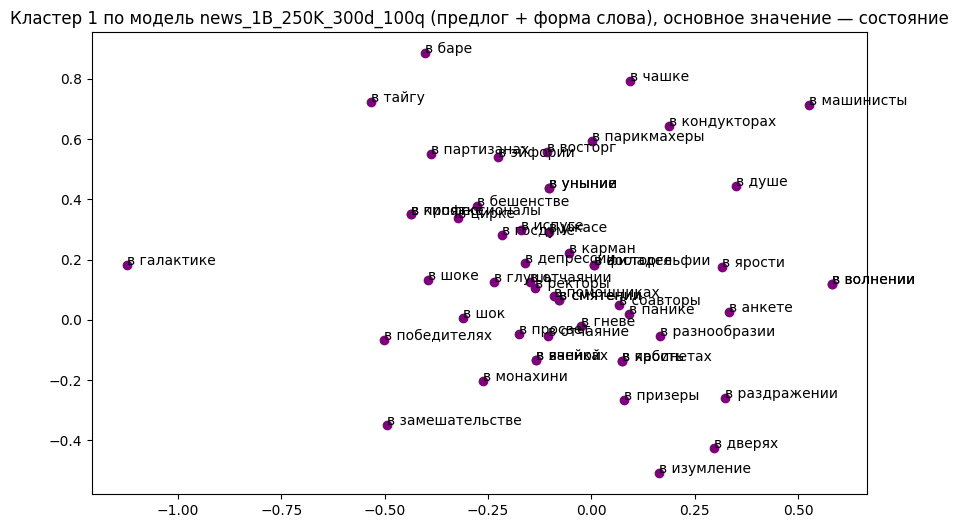

In [ ]:
visual_cl(mtrxs[1], mini_dfs[1], "Кластер 1 по модель news_1B_250K_300d_100q (предлог + форма слова), основное значение — состояние", "Purple")

**Модель news:**

In [ ]:
df_news.clusters_news.unique()
mini_dfs_ = [df_news.loc[df_news['clusters_news'] == cl] for cl in df_news.clusters_news.unique()]

mtrxs_ = []
for m_df in mini_dfs_:
    vecs = [vec for vec in m_df["vecs_news"]]
    mtrxs_.append(np.array(vecs))

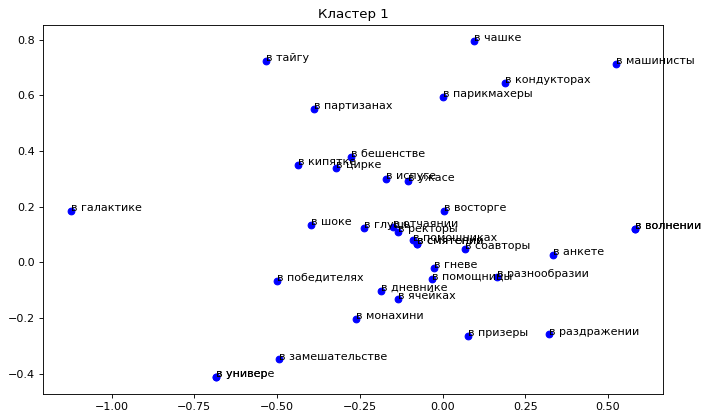

In [ ]:
visual_cl(mtrxs_[0], mini_dfs_[0], "Кластер 1", "Blue")

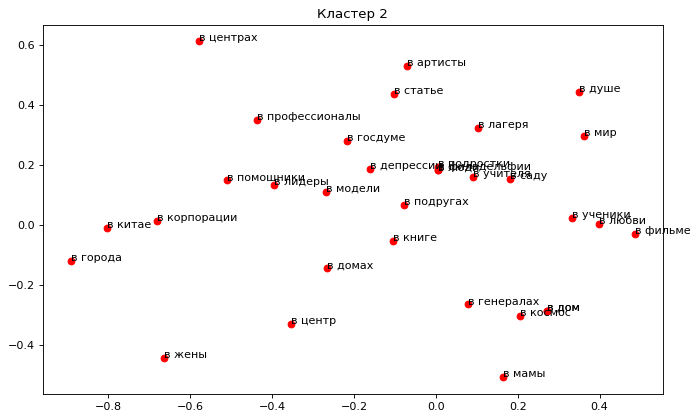

In [ ]:
visual_cl(mtrxs_[1], mini_dfs_[1], "Кластер 2", "Red")

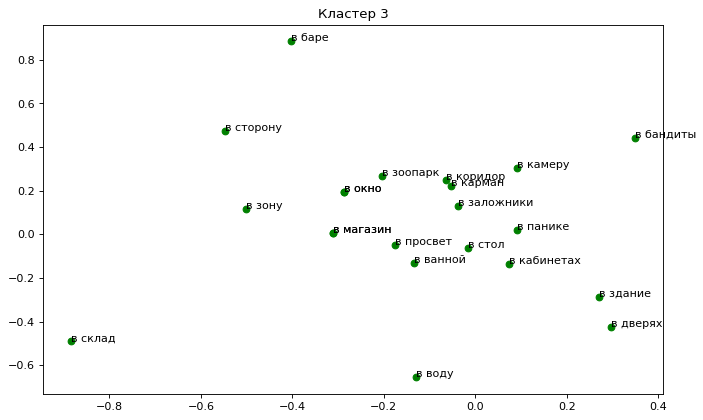

In [ ]:
visual_cl(mtrxs_[2], mini_dfs_[2], "Кластер 3", "Green")

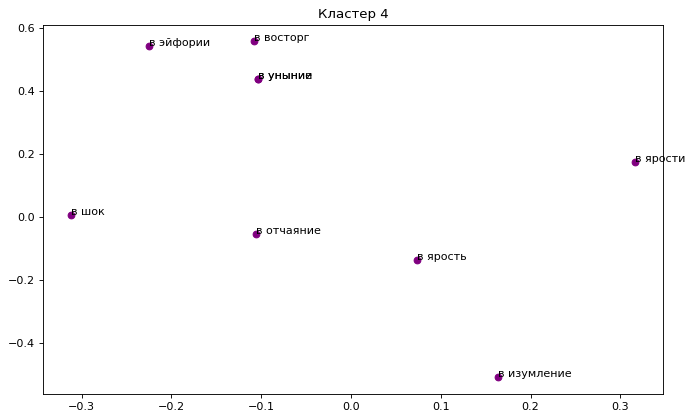

In [ ]:
visual_cl(mtrxs_[3], mini_dfs_[3], "Кластер 4", "Purple")

### Близкие токены

часть кода взята [отсюда](https://www.cs.toronto.edu/~lczhang/321/lec/glove_notes.html) и вроде [отсюда](https://github.com/Harvard-ATG/visualizing_russian_tools/blob/598482feb4e9495f9a6f777fecaf4ebee7daca94/parser_tool/navec.py#L17)

In [ ]:
from numpy import dot
from numpy.linalg import norm

In [ ]:
def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))

In [ ]:
words_vecs_hudlit = {}                            
for w in navec_lit.vocab.words:
    words_vecs_hudlit[w] = navec_lit[w]

In [ ]:
words_vecs_news = {}                            
for w in navec_news.vocab.words:
    words_vecs_news[w] = navec_news[w]

In [ ]:
def print_closest_words(prepvec, words_vecs, n=5):
    dists = {}
    for w, v in words_vecs.items():
        dist = cos_sim(prepvec, v)
        dists[w] = dist
    lst = sorted(dists.items(), key=operator.itemgetter(1), reverse = True)
    return lst[:n]

lit_vecs = print_closest_words(navec_lit["в"], words_vecs_hudlit, n=11)
news_vecs = print_closest_words(navec_news["в"], words_vecs_news, n=11)

<ipython-input-86-26d937acee0f>:2: RuntimeWarning: invalid value encountered in float_scalars
  return dot(a, b)/(norm(a)*norm(b))


In [ ]:
lit_vecs

[('в', 1.0),
 ('во', 0.6342994),
 ('этом', 0.5236187),
 ('где', 0.5229852),
 ('там', 0.49909192),
 ('самом', 0.48675227),
 ('туда', 0.48606822),
 ('том', 0.4856691),
 ('одном', 0.4749879),
 ('и', 0.47485244),
 ('здесь', 0.47127363)]

In [ ]:
news_vecs

[('в', 1.0),
 ('же', 0.5771349),
 ('этом', 0.56960016),
 ('во', 0.5659612),
 ('говорится', 0.5659172),
 ('года', 0.55980325),
 ('где', 0.5558794),
 ('кроме', 0.5340522),
 ('того', 0.53234917),
 ('так', 0.5280931),
 ('году', 0.5279955)]